In [ ]:
# !pip install keras-cv
# !pip install dill

In [1]:
# Importing dependencies
import os
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
from jupyter_client.consoleapp import classes
from tensorboard.plugins.image.summary import image
from tensorflow.keras import *
from tensorflow.keras.optimizers import AdamW
import keras_cv

BATCH_SIZE = 8
GLOBAL_CLIPNORM = 10.0
bounding_box_format = "center_xywh"
AUTO = tf.data.AUTOTUNE
EPOCHS = 1

D:\chientuhocai\Traffic_Sign\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices=false'

# 1. Preprocessing

In [3]:
# a function for converting txt file to list
def parse_txt_annot(img_path, txt_path):
    #read image and get shape
    img = cv2.imread(img_path)
    w = int(img.shape[0])
    h = int(img.shape[1])

    #read label file
    file_label = open(txt_path, "r")
    lines = file_label.read().split('\n')

    boxes = []
    classes = []

    for i in range(0, int(len(lines))):
        # check line is empty or not
        if lines[i] == '':
            continue
        objbud = lines[i].split(' ')
        try:
            class_ = int(objbud[0])
            x1 = float(objbud[1])
            y1 = float(objbud[2])
            w1 = float(objbud[3])
            h1 = float(objbud[4])
        except Exception as e:
            print(e, txt_path)
            continue
        # convert to x_center, y_center, width, height
        x_center = int((x1 * w))
        y_center = int((y1 * h))
        width = int((w1 * w))
        height = int((h1 * h))

        boxes.append([x_center, y_center, width, height])
        classes.append(class_)

    return img_path, classes, boxes


# a function for creating file paths list
def create_paths_list(path):
    full_path = []
    images = sorted(os.listdir(path))

    for i in images:
        full_path.append(os.path.join(path, i))

    return full_path


class_ids = class_labels = [
    "sign",
]

class_mapping = dict(zip(range(len(class_ids)), class_ids))
num_classes = len(class_ids)

In [4]:
# a function for creating a dict format of files
def creating_files(img_files_paths, annot_files_paths):
    # get list of image and annotation files
    img_files = create_paths_list(img_files_paths)
    annot_files = create_paths_list(annot_files_paths)

    image_paths = []
    bbox = []
    classes = []

    for i in range(0, len(img_files)):
        try:
            # parse txt annotation file - get image path, classes and bounding boxes
            image_path_, classes_, bbox_ = parse_txt_annot(img_files[i], annot_files[i])
            image_paths.append(image_path_)
            bbox.append(bbox_)
            classes.append(classes_)
        except Exception as e:
            # remove the image and annotation file if there is an error
            print(e, img_files[i])
            continue

    image_paths = tf.ragged.constant(image_paths)
    bbox = tf.ragged.constant(bbox)
    classes = tf.ragged.constant(classes)

    return image_paths, classes, bbox

In [5]:
# orin_path='/kaggle/input/detection-traffic-sign-mix/dataset'
orin_path = '../dataset/detect_1/dataset'


In [6]:
# applying functions
train_img_paths, train_classes, train_bboxes = creating_files(f'{orin_path}/train/images',
                                                              f'{orin_path}/train/labels')
print("Finished creating training files")
valid_img_paths, valid_classes, valid_bboxes = creating_files(f'{orin_path}/valid/images',
                                                              f'{orin_path}/valid/labels')
print('Finished creating validation files')
test_img_paths, test_classes, test_bboxes = creating_files(f'{orin_path}/test/images',
                                                           f'{orin_path}/test/labels')
print('Finished creating testing files')

Finished creating training files
Finished creating validation files
Finished creating testing files


## Creating Dataset

In [7]:
# reading and resizing images
def img_preprocessing(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32)
    return img


# JitteredResize for data augmentation
resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(0.75, 1.3),
    bounding_box_format=bounding_box_format)

rescaling = keras_cv.layers.Rescaling(1.0 / 255)


# loading dataset
def load_ds(img_paths, classes, bbox):
    img = img_preprocessing(img_paths)

    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox}

    return {"images": img, "bounding_boxes": bounding_boxes}


def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]

In [8]:
# Creating dataset loaders and tf.datasets
train_loader = tf.data.Dataset.from_tensor_slices((train_img_paths, train_classes, train_bboxes))
train_dataset = (train_loader
                 .map(load_ds, num_parallel_calls=AUTO)
                 .shuffle(BATCH_SIZE * 10)
                 .ragged_batch(BATCH_SIZE, drop_remainder=True)
                 .map(rescaling, num_parallel_calls=AUTO)
                 .map(resizing, num_parallel_calls=AUTO)
                 .map(dict_to_tuple, num_parallel_calls=AUTO)
                 .prefetch(AUTO))

print("Finished creating training dataset")
valid_loader = tf.data.Dataset.from_tensor_slices((valid_img_paths, valid_classes, valid_bboxes))
valid_dataset = (valid_loader
                 .map(load_ds, num_parallel_calls=AUTO)
                 .ragged_batch(BATCH_SIZE, drop_remainder=True)
                 .map(resizing, num_parallel_calls=AUTO)
                 .map(resizing, num_parallel_calls=AUTO)
                 .map(dict_to_tuple, num_parallel_calls=AUTO)
                 .prefetch(AUTO))

print("Finished creating validation dataset")
test_loader = tf.data.Dataset.from_tensor_slices((test_img_paths, test_classes, test_bboxes))
test_dataset = (test_loader
                .map(load_ds, num_parallel_calls=AUTO)
                .ragged_batch(BATCH_SIZE, drop_remainder=True)
                .map(resizing, num_parallel_calls=AUTO)
                .map(resizing, num_parallel_calls=AUTO)
                .map(dict_to_tuple, num_parallel_calls=AUTO)
                .prefetch(AUTO))
print("Finished creating testing dataset")

Finished creating training dataset
Finished creating validation dataset
Finished creating testing dataset


In [9]:
def preprocess_data(images, labels):
    # Trích xuất classes và boxes từ labels
    classes = labels['classes']
    boxes = labels['boxes']

    # Chuyển đổi RaggedTensor thành Tensor với padding
    classes = classes.to_tensor(default_value=-1.0)  # Padding classes
    boxes = boxes.to_tensor(default_value=0.0)  # Padding boxes

    # Đảm bảo boxes có shape (batch_size, num_boxes, 4)
    boxes = tf.reshape(boxes, (tf.shape(boxes)[0], -1, 4))

    # Đảm bảo classes có shape (batch_size, num_boxes)
    classes = tf.reshape(classes, (tf.shape(classes)[0], -1))

    # Trả về images và labels đã xử lý
    return images, {'classes': classes, 'boxes': boxes}


# Áp dụng hàm lên dataset
train_dataset = train_dataset.map(preprocess_data)
valid_dataset = valid_dataset.map(preprocess_data)
test_dataset = test_dataset.map(preprocess_data)

In [10]:
# a function to visualize samples from a dataset
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs[0], inputs[1]

    keras_cv.visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=8,
        font_scale=0.8,
        line_thickness=2,
        dpi=100,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
        true_color=(192, 57, 43))

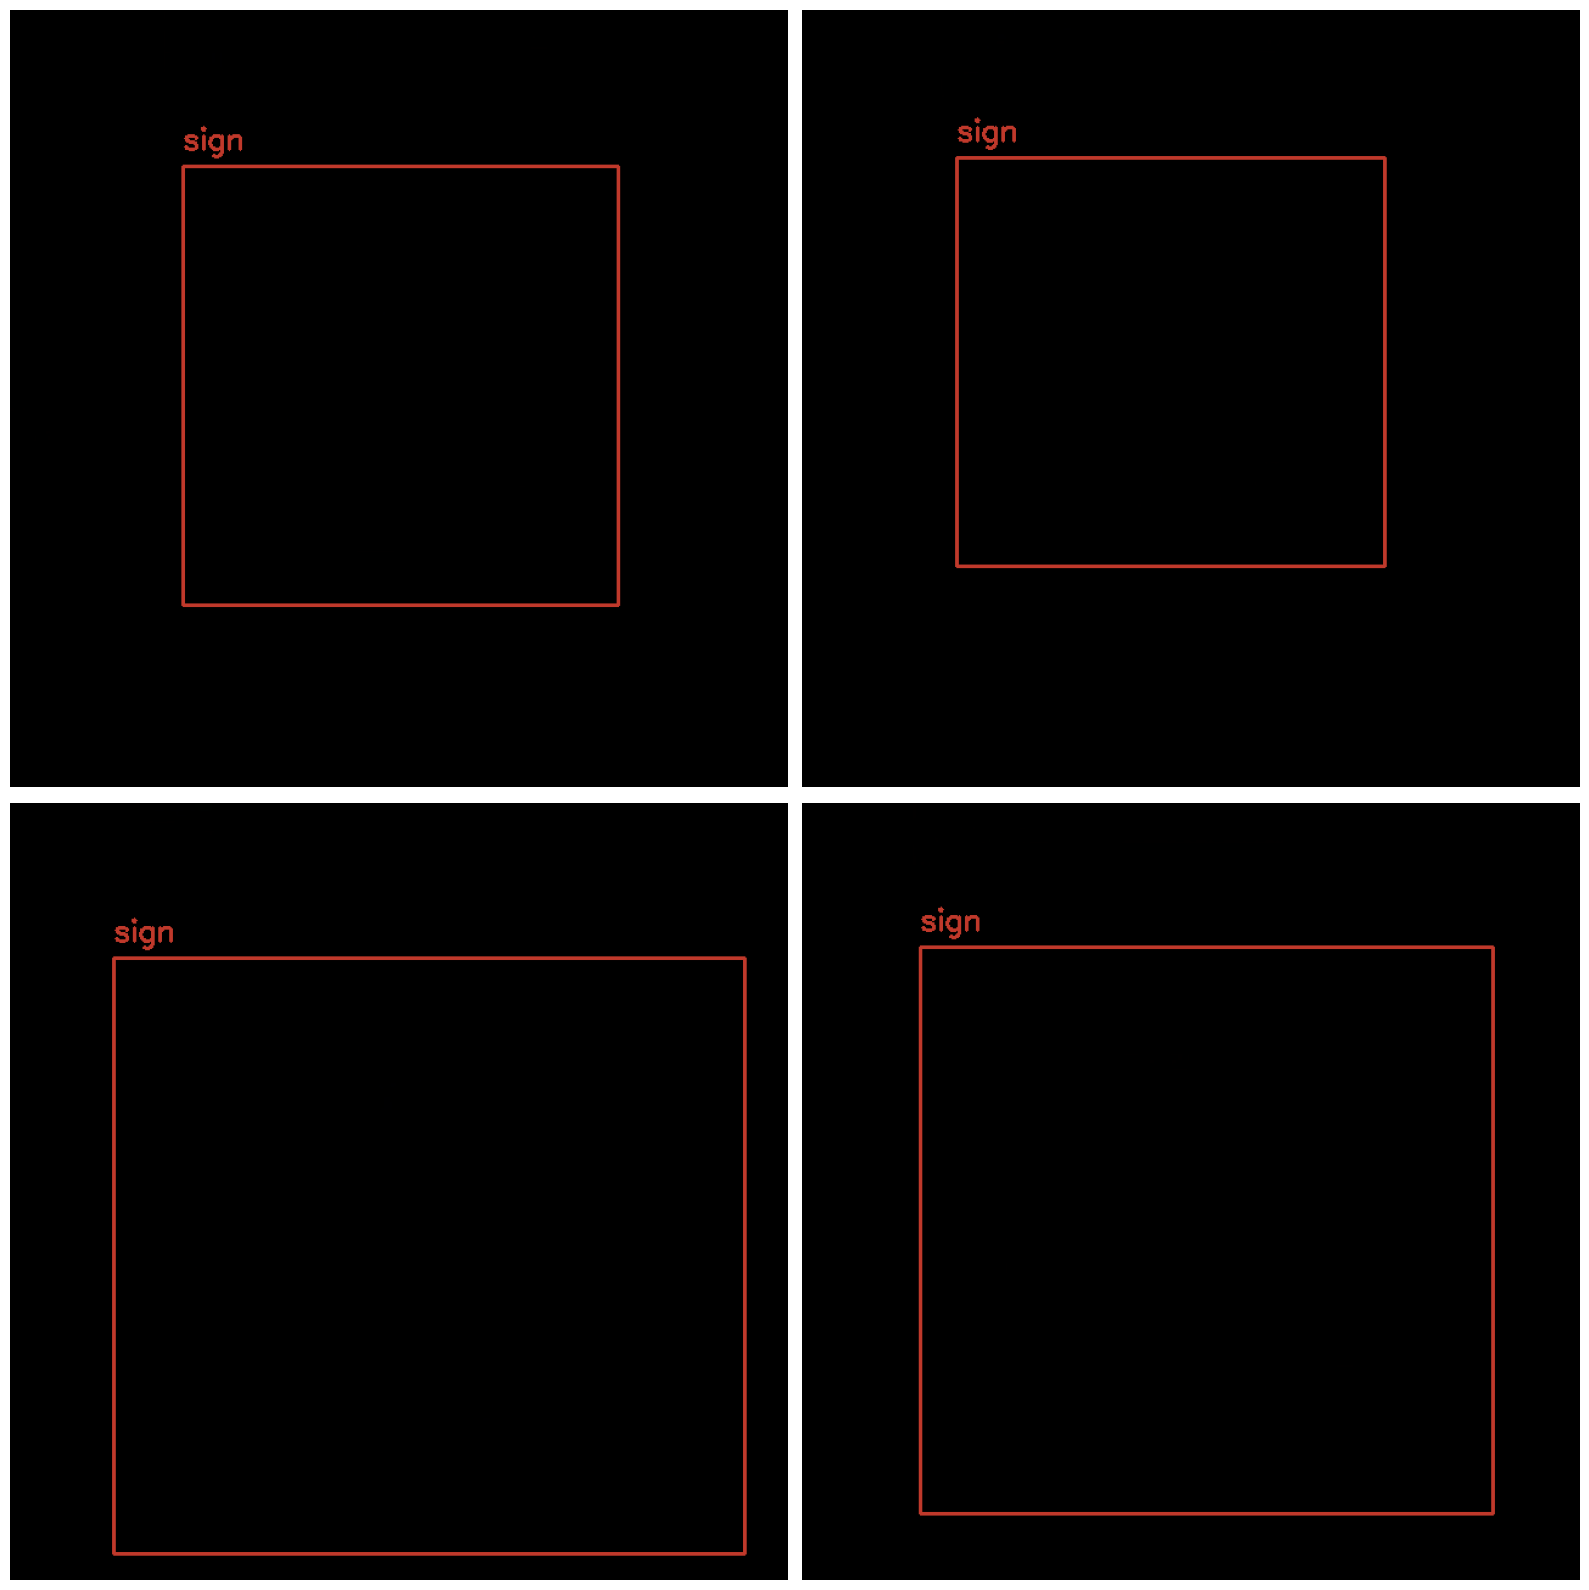

In [11]:
# examples images and annotations from training daatset
visualize_dataset(train_dataset, bounding_box_format=bounding_box_format, value_range=(0, 255), rows=2, cols=2)

# 2. Model

In [12]:
# !nvidia-smi

In [13]:
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))  # Kiểm tra GPU
# 
# # Thiết lập mixed precision để tăng tốc độ trên GPU (tùy chọn)
# tf.keras.mixed_precision.set_global_policy('float32')  #

In [14]:
def create_model(
        num_classes=1,
        input_shape=(640, 640, 3),  # Định dạng chuẩn cho YOLO
        fpn_depth=1,
        learning_rate=0.001,
        weight_decay=0.004,
        use_pretrained=True,  # Thêm flag để kiểm soát việc sử dụng pre-trained
        trainable=False,  # Thêm flag để kiểm soát việc đóng băng backbone
        iou_threshold=0.7
):
    # Tải pre-trained backbone ----------------------------------------------------
    if use_pretrained:
        backbone = keras_cv.models.YOLOV8Backbone.from_preset(
            "yolo_v8_m_backbone_coco",  # Pre-trained trên COCO
            input_shape=input_shape
        )
        print("Loaded pre-trained YOLOv8 backbone")
    else:
        backbone = keras_cv.models.YOLOV8Backbone(
            input_shape=input_shape
        )
    # Define custom NMS decoder with IoU threshold
    prediction_decoder = keras_cv.layers.MultiClassNonMaxSuppression(
        iou_threshold=iou_threshold,  # Your IoU threshold (default: 0.7)
        confidence_threshold=0.05,  # Minimum confidence to keep predictions
        bounding_box_format=bounding_box_format,  # Match your format
        max_detections=300,  # Optional: max boxes per image
        from_logits=False  # Whether to apply sigmoid on confidence
    )

    # Tạo model với pre-trained backbone và custom head ---------------------------
    model = keras_cv.models.YOLOV8Detector(
        num_classes=num_classes,
        bounding_box_format=bounding_box_format,
        backbone=backbone,
        fpn_depth=fpn_depth,
        prediction_decoder=prediction_decoder
    )

    # Đóng băng backbone (tùy chọn) -----------------------------------------------
    # Chỉ images các layer detection head
    backbone.trainable = trainable  # Đóng băng toàn bộ backbone

    # Hoặc đóng băng một phần:
    # for layer in backbone.layers[:-5]:  # Giữ lại 5 layer cuối để fine-tune
    #     layer.trainable = False

    # Cấu hình optimizer ----------------------------------------------------------
    optimizer = AdamW(
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        global_clipnorm=10.0  # Thêm clipnorm để ổn định training
    )

    # Compile model ---------------------------------------------------------------
    model.compile(
        optimizer=optimizer,
        classification_loss=tf.keras.losses.BinaryFocalCrossentropy(
            from_logits=True,
            gamma=2.0
        ),
        box_loss=keras_cv.losses.CIoULoss(
            bounding_box_format=bounding_box_format
        ),
        jit_compile=False
    )

    return model

In [15]:
# with tf.device('/device:GPU:0'):
#     model = create_model(num_classes=len(class_ids))

In [26]:
from keras.utils import custom_object_scope
from keras_cv.models import YOLOV8Detector
from keras_cv.losses import CIoULoss

def load_model(model_path):
    custom_objects = {
        'YOLOV8Detector': YOLOV8Detector,
        'CIoULoss': CIoULoss(bounding_box_format='center_xywh')
    }
    
    with tf.keras.utils.custom_object_scope(custom_objects):
        model = tf.keras.models.load_yolo_model(model_path)
        
        optimizer = AdamW(
            learning_rate=1e-4,
            weight_decay=0.0009,
            global_clipnorm=10.0  # Thêm clipnorm để ổn định training
        )

        # Manually compile if needed
        if not hasattr(model, '_is_compiled') or not model._is_compiled:
            model.compile(
                optimizer=optimizer,
                classification_loss=tf.keras.losses.BinaryCrossentropy(
                    from_logits=False,
                    label_smoothing=0.1,
                ),
                box_loss=keras_cv.losses.CIoULoss(
                    bounding_box_format=bounding_box_format,            
                    reduction="sum"
                )
            )
    
    return model

In [27]:
# load model from .keras file
model = load_model('../model/YOLOV8_model.keras')
# model=create_model()

In [28]:
model.summary()

Model: "yolov8_detector_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 640, 640,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_4        │ [(None, 80, 80,   │ 11,872,464 │ input_layer_9[0]… │
│ (Functional)        │ 192), (None, 40,  │            │                   │
│                     │ 40, 384), (None,  │            │                   │
│                     │ 20, 20, 576)]     │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_16 (Repeat)  │ (None, 40, 20,    │          0 │ functional_4[0][… │
│                     │ 576)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_17 (Repeat)  │ (None, 40, 40,    │          0 │ repeat_16[0][0]   │
│                     │ 576)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_73      │ (None, 40, 40,    │          0 │ repeat_17[0][0],  │
│ (Concatenate)       │ 960)              │            │ functional_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pa_fpn_p4p5_pre_co… │ (None, 40, 40,    │    368,640 │ concatenate_73[0… │
│ (Conv2D)            │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pa_fpn_p4p5_pre_bn  │ (None, 40, 40,    │      1,536 │ pa_fpn_p4p5_pre_… │
│ (BatchNormalizatio… │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pa_fpn_p4p5_pre     │ (None, 40, 40,    │          0 │ pa_fpn_p4p5_pre_… │
│ (Activation)        │ 384)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ split_36 (Split)    │ [(None, 40, 40,   │          0 │ pa_fpn_p4p5_pre[… │
│                     │ 192), (None, 40,  │            │                   │
│                     │ 40, 192)]         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pa_fpn_p4p5_pre_0_… │ (None, 42, 42,    │          0 │ split_36[0][1]    │
│ (ZeroPadding2D)     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pa_fpn_p4p5_pre_0_… │ (None, 40, 40,    │    331,776 │ pa_fpn_p4p5_pre_… │
│ (Conv2D)            │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pa_fpn_p4p5_pre_0_… │ (None, 40, 40,    │        768 │ pa_fpn_p4p5_pre_… │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pa_fpn_p4p5_pre_0_1 │ (None, 40, 40,    │          0 │ pa_fpn_p4p5_pre_… │
│ (Activation)        │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pa_fpn_p4p5_pre_0_… │ (None, 42, 42,    │          0 │ pa_fpn_p4p5_pre_… │
│ (ZeroPadding2D)     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pa_fpn_p4p5_pre_0_… │ (None, 40, 40,    │    331,776 │ pa_fpn_p4p5_pre_… │
│ (Conv2D)            │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pa_fpn_p4p5_pre_0_… │ (None, 40, 40,    │        768 │ pa_fpn_p4p5_pre_

 Total params: 24,966,099 (95.24 MB)

 Trainable params: 24,934,131 (95.12 MB)

 Non-trainable params: 31,968 (124.88 KB)

In [ ]:
# tf.keras.utils.plot_model(model, show_shapes=True, dpi=96)

## Results and Evaluation

In [29]:
model.evaluate(test_dataset)

D:\chientuhocai\Traffic_Sign\.venv\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1288']
Received: inputs=Tensor(shape=(8, 640, 640, 3))
  warnings.warn(msg)


201/201 ━━━━━━━━━━━━━━━━━━━━ 479s 2s/step - box_loss: 0.5433 - class_loss: 0.0166 - loss: 0.5600


[0.5644120573997498, 0.5408124923706055, 0.02359967678785324]

In [30]:
def visualize_predict_detections(model, dataset, bounding_box_format, class_mapping=None, conf_threshold=0.5):
    # Lấy 1 batch từ dataset
    images, y_true = next(iter(dataset.take(1)))

    # Dự đoán
    y_pred = model.predict(images, verbose=0)

    # Lọc các boxes dựa trên confidence và chuyển về Tensor
    # --------------------------------------------------------
    # Lấy confidence và tạo mask
    confidence = y_pred['confidence']
    mask = confidence >= conf_threshold  # Lọc boxes có confidence >= ngưỡng

    # Áp dụng mask để lọc boxes và classes
    filtered_boxes = tf.boolean_mask(y_pred['boxes'], mask)
    filtered_classes = tf.boolean_mask(y_pred['classes'], mask)

    # Đếm số lượng boxes hợp lệ cho mỗi ảnh
    num_boxes = tf.reduce_sum(tf.cast(mask, tf.int32), axis=1)

    # Chuyển về Tensor với padding (shape: [batch_size, max_boxes, ...])
    padded_boxes = tf.RaggedTensor.from_row_lengths(filtered_boxes, num_boxes).to_tensor(default_value=0.0)
    padded_classes = tf.RaggedTensor.from_row_lengths(filtered_classes, num_boxes).to_tensor(default_value=-1)

    # Tạo y_pred dạng Tensor
    y_pred_tensor = {
        'boxes': padded_boxes,
        'classes': padded_classes
    }

    # Xử lý ảnh đầu vào
    # --------------------------------------------------------
    images = images.numpy()
    if tf.reduce_max(images) <= 1.0:
        images = (images * 255).astype("uint8")

    # Visualize
    # --------------------------------------------------------
    keras_cv.visualization.plot_bounding_box_gallery(
        images=images,
        value_range=(0, 255),  # Thêm value_range
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred_tensor,
        true_color=(192, 57, 43),  # Màu đỏ
        pred_color=(255, 235, 59),  # Màu vàng
        scale=4,
        font_scale=0.7,
        line_thickness=2,
        dpi=100,
        rows=2,
        cols=2,
        show=True,
        class_mapping=class_mapping or {}
    )

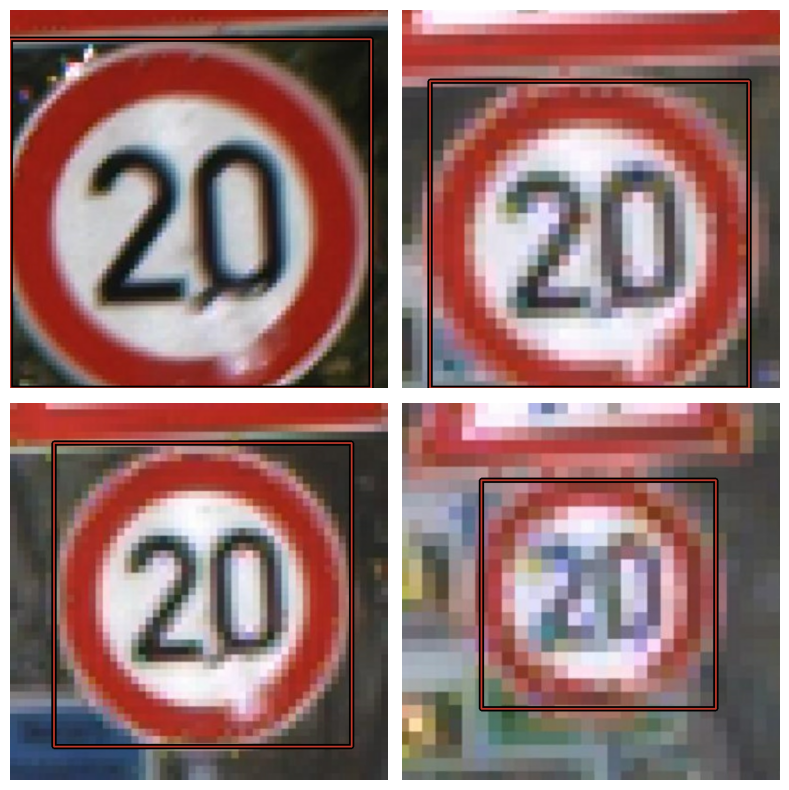

In [31]:
visualize_predict_detections(model, dataset=train_dataset, bounding_box_format=bounding_box_format, conf_threshold=0)

In [ ]:
def calculate_iou(model, dataset, bounding_box_format, conf_threshold=0.5):
    """
    Tính toán IoU giữa predictions và ground truth.

    Args:
        model: Mô hình object detection.
        dataset: Tập dữ liệu (tf.data.Dataset) chứa ảnh và ground truth.
        bounding_box_format: Định dạng bounding box (ví dụ: "xywh", "xyxy").
        conf_threshold: Ngưỡng tin cậy để lọc các boxes dự đoán.

    Returns:
        mean_iou: IoU trung bình cho từng ảnh trong batch.
    """
    # Lấy 1 batch từ dataset
    images, y_true = next(iter(dataset.take(1)))

    # Dự đoán
    y_pred = model.predict(images, verbose=0)

    # Lọc các boxes dựa trên confidence và chuyển về Tensor
    # --------------------------------------------------------
    # Lấy confidence và tạo mask
    confidence = y_pred['confidence']
    mask = confidence >= conf_threshold  # Lọc boxes có confidence >= ngưỡng

    # Áp dụng mask để lọc boxes và classes
    filtered_boxes = tf.boolean_mask(y_pred['boxes'], mask)
    filtered_classes = tf.boolean_mask(y_pred['classes'], mask)

    # Đếm số lượng boxes hợp lệ cho mỗi ảnh
    num_boxes = tf.reduce_sum(tf.cast(mask, tf.int32), axis=1)

    # Chuyển về Tensor với padding (shape: [batch_size, max_boxes, ...])
    padded_boxes = tf.RaggedTensor.from_row_lengths(filtered_boxes, num_boxes).to_tensor(default_value=0.0)
    padded_classes = tf.RaggedTensor.from_row_lengths(filtered_classes, num_boxes).to_tensor(default_value=-1)

    # Tạo y_pred dạng Tensor
    y_pred_tensor = {
        'boxes': padded_boxes,
        'classes': padded_classes
    }

    # Tính toán IoU giữa predictions và ground truth
    # --------------------------------------------------------
    iou_matrix = keras_cv.bounding_box.compute_iou(
        y_pred_tensor['boxes'],  # Predictions
        y_true['boxes'],  # Ground truth
        bounding_box_format=bounding_box_format
    )

    # Lấy IoU trung bình cho mỗi ảnh
    mean_iou = tf.reduce_mean(iou_matrix, axis=1).numpy()
    return mean_iou

In [ ]:
mean_iou = calculate_iou(model, dataset=train_dataset, bounding_box_format=bounding_box_format)

In [ ]:
mean_iou